# Sentiment Analysis using Word Embedding

Citations:
- https://nlp.stanford.edu/projects/glove/
- https://medium.com/@jonathan_hui/nlp-word-embedding-glove-5e7f523999f6
- https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010
- http://www.davidsbatista.net/blog/2018/03/31/SentenceClassificationConvNets/
- https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7
- https://machinelearningmastery.com/what-are-word-embeddings/
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Word Embedding
Word embeddings are a type of word representation that allows words with similar meaning or co-occurring words to have a similar representation. Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.

## Word2Vec
Word2Vec is a statistical method for efficiently learning a standalone word embedding from a text corpus.

It was developed by Tomas Mikolov, et al. at Google in 2013 as a response to make the neural-network-based training of the embedding more efficient and since then has become the de facto standard for developing pre-trained word embedding.

Additionally, the work involved analysis of the learned vectors and the exploration of vector math on the representations of words. For example, that subtracting the “man-ness” from “King” and adding “women-ness” results in the word “Queen“, capturing the analogy “king is to queen as man is to woman“.

Two different learning models:
- The CBOW model learns the embedding by predicting the current word based on its context. 
- The continuous skip-gram model learns by predicting the surrounding words given a current word.
Both models are focused on learning about words given their local usage context, where the context is defined by a window of neighboring words. This window is a configurable parameter of the model.

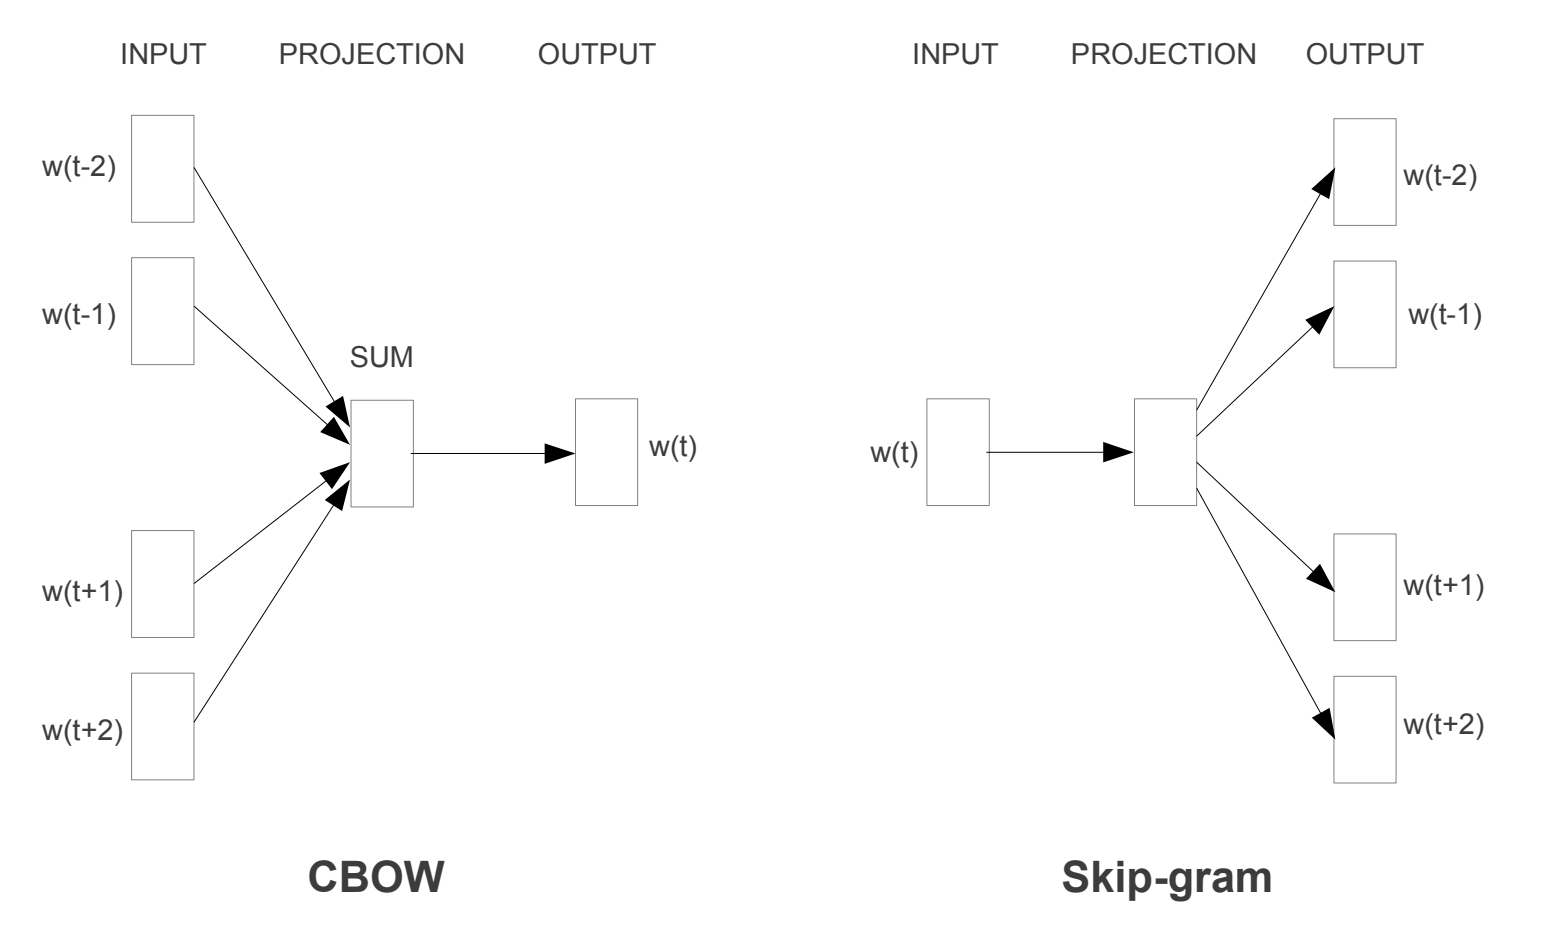

In [50]:
Image(filename='images/w2v.png', width=700)

## GloVE
The Global Vectors for Word Representation, or GloVe, algorithm is an extension to the Word2Vec method for efficiently learning word vectors, developed by Pennington, et al. at Stanford.

Classical vector space model representations of words were developed using matrix factorization techniques such as Latent Semantic Analysis (LSA) that do a good job of using global text statistics but are not as good as the learned methods like word2vec at capturing meaning and demonstrating it on tasks like calculating analogies (e.g. the King and Queen example above).

GloVe is an approach to marry both the global statistics of matrix factorization techniques like LSA with the local context-based learning in word2vec.

Rather than using a window to define local context, GloVe constructs an explicit word-context or word co-occurrence matrix using statistics across the whole text corpus. The result is a learning model that may result in generally better word embeddings.

In [20]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, LSTM, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df = pd.read_csv('../../data/Reviews.csv')
df['Text'] = df['Text'] + ' ' + df['Summary']

In [3]:
# Delete unused columns
del df['Id']
del df['ProfileName']
del df['Summary']
del df['HelpfulnessNumerator']
del df['HelpfulnessDenominator']
del df['Time']
del df['ProductId']

In [4]:
df.head()

,UserId,Score,Text
0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...


In [5]:
df.loc[df['Score'] <= 3, 'ReviewSentiment'] = 0
df.loc[df['Score'] > 3, 'ReviewSentiment'] = 1

df['ReviewSentiment'] = df['ReviewSentiment'].astype(int)

In [6]:
df.isna().sum()

UserId              0
Score               0
Text               27
ReviewSentiment     0
dtype: int64

In [7]:
#convert na to ""
df['Text'].fillna("", inplace=True)

In [8]:
def preprocess(s):
    # Remove html tags
    s = re.sub('<\S+>', '', s)
    # Replace urls with token
    s = re.sub(r'http:\S+', 'url', s)
    s = re.sub(r'https:\S+', 'url', s)
    
    s = s.lower()
    # Remove any other special characters
    s = re.sub(r'[^a-z ]', ' ', s)
    
    words = s.split()
    result = []
    
    # Remove stop words and lemmatize the words
    for word in words:
        if word in stop_words:
            continue
        word = lemmatizer.lemmatize(word)
        result.append(word)
    return ' '.join(result)

df['Text'] = df['Text'].apply(preprocess)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df['Text'], df['ReviewSentiment'], test_size=0.2, random_state=1, stratify=df['ReviewSentiment'])
print('Number of train samples:', len(x_train))
print('Number of test samples:', len(x_test))

Number of train samples: 454763
Number of test samples: 113691


In [11]:
# Delete unused objects
del stop_words
del lemmatizer
del df

## Logistic Regression using Pre-trained Glove Word Embeddings

Using pre-trained GloVE vectors downloaded from https://nlp.stanford.edu/projects/glove/

In [10]:
# Read the pre-trainined word embeddings
embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding="utf8") as f:
    line = f.readline()
    while line:
        values = line.split()
        word = values[0]
        try:
           coefs = np.asarray(values[1:], dtype='float32')
           embeddings_index[word] = coefs
        except ValueError:
           pass
        line = f.readline()


In [11]:
def doc2vec(s):
    '''Convert document to vector
    s: string to be converted to vector using Glove word embeddings
    return: numpy array'''
    words = word_tokenize(s)
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    # Normalize the vector
    return v / np.sqrt((v ** 2).sum())

In [15]:
xtrain_glove = [doc2vec(x) for x in tqdm(x_train)]

In [17]:
xtest_glove = [doc2vec(x) for x in tqdm(x_test)]

In [ ]:
print('Starting GridSearchCV Training...')
# Because we have an imbalanced data set, using 'balanced' class_weight
lr = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, class_weight='balanced', verbose=1)
parameters = {'C':[2,5,8,10]}
grid_cv = GridSearchCV(lr, parameters)
grid_cv.fit(xtrain_glove, y_train.tolist())
print('GridSearchCV Training Complete.')

In [23]:
pickle.dump(grid_cv, open('model/lr_glove_grid_model', 'wb'))
loaded_grid_cv = pickle.load(open('model/lr_glove_grid_model', 'rb'))
print('Loaded GridCV Model on test data:', loaded_grid_cv.score(xtest_glove, y_test.tolist()))

Loaded GridCV Model on test data: 0.8092285229261771


Text(0.5, 1.0, 'C vs Mean Test Score')

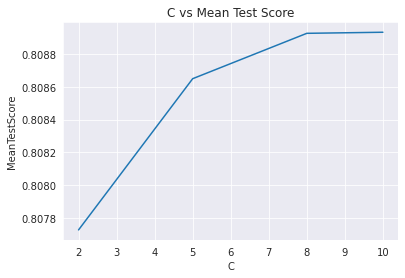

In [25]:
sns.set_style("darkgrid")

C = []
mean_acc = []
for i, param in enumerate(loaded_grid_cv.cv_results_['params']):
    C.append(param['C'])
    mean_acc.append(loaded_grid_cv.cv_results_['mean_test_score'][i])
data = pd.DataFrame({'C':C, 'MeanTestScore':mean_acc})

sns.lineplot(x='C',y='MeanTestScore', data=data, ci= None).set_title('C vs Mean Test Score')

After C=9, the mean test score flattens. This is an exercise to find out if using Glove word embeddings to convert documents to vectors and use them in Logistic Regression to classify sentiment. We infer this did not give better accuracy than performing Logistic Regression on TF-IDF feature vectors.

# Convolutional Neural Networks

ConvNets were initially developed in the neural network image processing community where they achieved break-through results in recognising an object from a pre-defined category (e.g., cat, bicycle, etc.).

A Convolutional Neural Network typically involves two operations, which can be though of as feature extractors: convolution and pooling. The output of this sequence of operations is then typically connected to a fully connected layer which is in principle the same as the traditional multi-layer perceptron neural network 

## Convolution

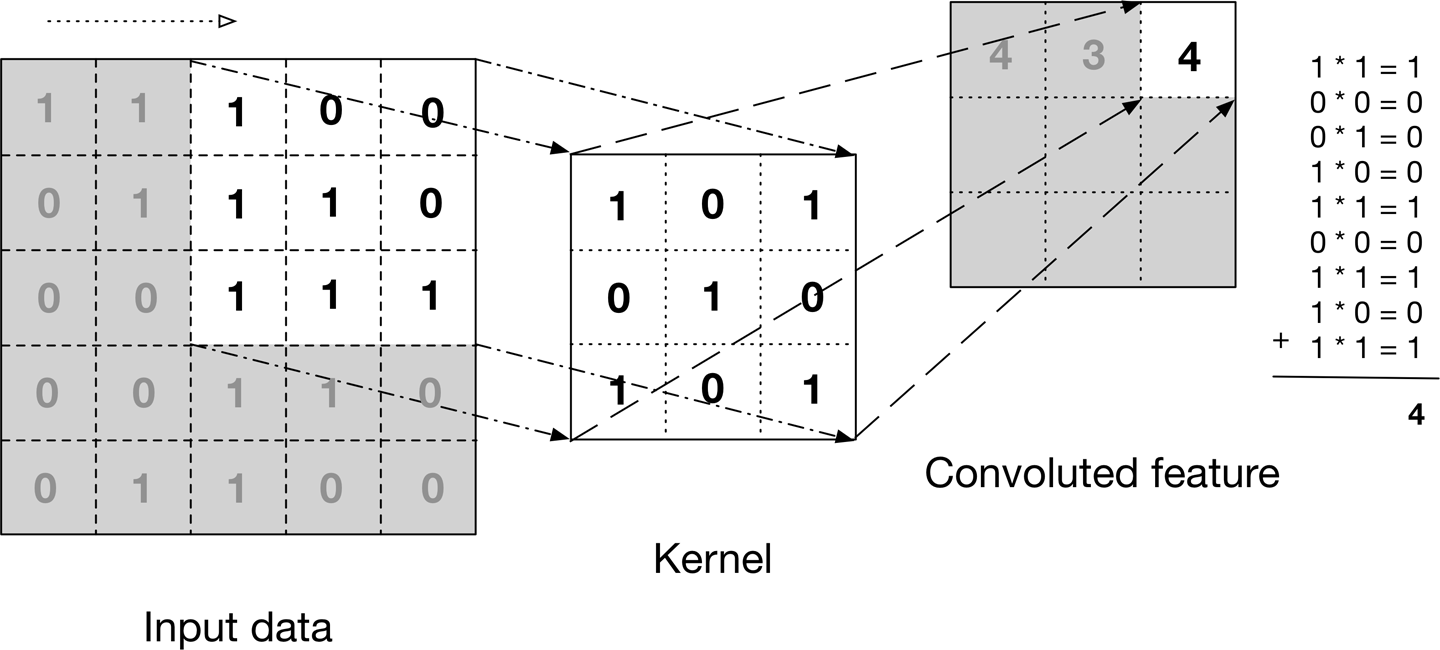

In [34]:
from IPython.display import Image
Image(filename='images/cnn_1.png', width=700)

One way to understand the convolution operation is to imagine placing the convolution filter or kernel on the top of the input image, positioned in a way so that the kernel and the image upper left corners coincide, and then multiplying the values of the input image matrix with the corresponding values in the convolution filter.

All of the multiplied values are then added together resulting in a single scalar, which is placed in the first position of a result matrix.

The kernel is then moved x pixels to the right, where x is denoted stride length and is a parameter of the ConvNet structure. The process of multiplication is then repeated, so that the next value in the result matrix is computed and filled.

## Pooling
Also known as downsampling layer, which consists of applying some operation over regions/patches in the input feature map and extracting some representative value for each of the analysed regions/patches.

Max-pooling selects the maximum of the values in the input feature map region of each step 

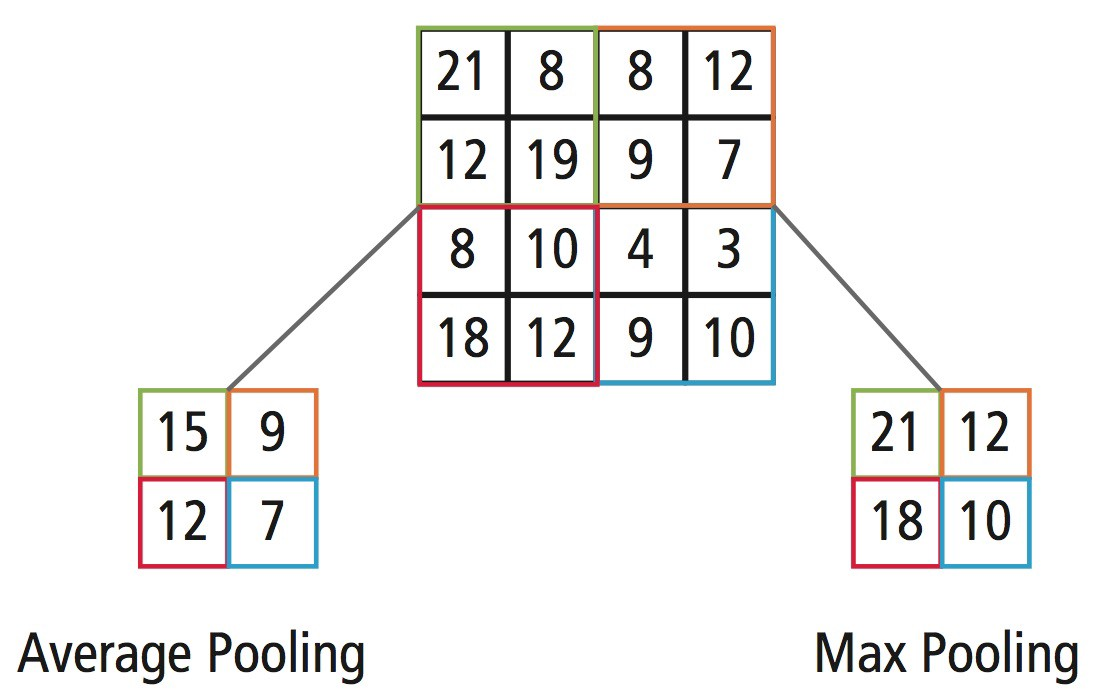

In [35]:
Image(filename='images/cnn_2.jpg', width=700)

## Fully Connected
We pass the extracted features, usually as a reshaped vector of one row, further to the network, for instance, a multi-layer perceptron to be trained for classification.

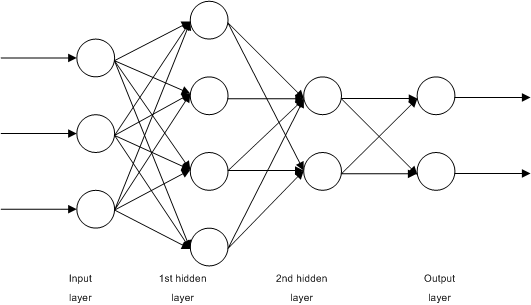

In [36]:
Image(filename='images/cnn_3.png', width=700)

## Activation Function
It is used to determine the output of neural network like yes or no. It maps the resulting values in between 0 to 1 or -1 to 1. (depending upon the function).

### ReLU
ReLU stands for rectified linear unit, and is a type of activation function. Mathematically, it is defined as _y = max(0, x)_. Visually, it looks like the following:

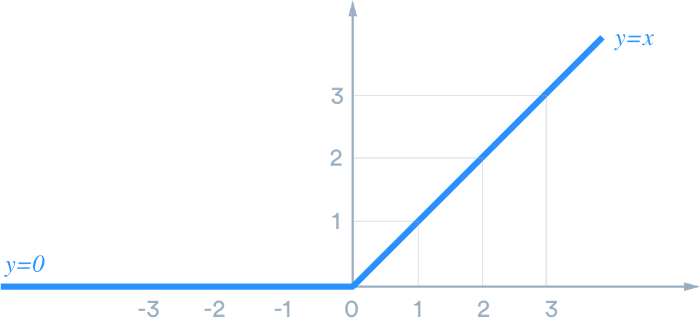

In [37]:
Image(filename='images/relu.png', width=700)

### Sigmoid
The main reason we use sigmoid function is because it exists between (0 to 1). Since our predictions are either positive or negative (0 or 1) this suits for our purpose.

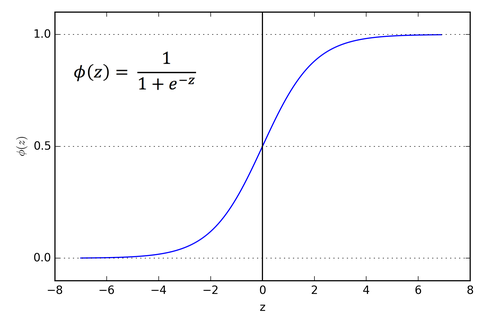

In [38]:
Image(filename='images/sigmoid.png', width=700)

Let us look at a convolutional neural network to predict the sentiment.

In [18]:
# Using a script computed the vocabulary size
vocabulary_size = 103726
max_len = 200
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
data = pad_sequences(sequences, maxlen=max_len)

In [19]:
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [19]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 300, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))

model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))

model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))

model_glove.add(Flatten())

model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Using class weight dictionary since the data is imbalanced.
class_weight = {0: 3.5,
                1: 1}

history = model_glove.fit(data, np.array(y_train), validation_split=0.4, class_weight=class_weight, epochs=30)

Train on 272857 samples, validate on 181906 samples
Epoch 1/30
272857/272857 [==============================] - 48s 175us/step - loss: 0.6822 - accuracy: 0.7950 - val_loss: 0.5976 - val_accuracy: 0.7992
Epoch 2/30
272857/272857 [==============================] - 42s 153us/step - loss: 0.5761 - accuracy: 0.8341 - val_loss: 0.5717 - val_accuracy: 0.8709
Epoch 3/30
272857/272857 [==============================] - 42s 154us/step - loss: 0.5284 - accuracy: 0.8508 - val_loss: 0.5357 - val_accuracy: 0.8589
Epoch 4/30
272857/272857 [==============================] - 41s 152us/step - loss: 0.4962 - accuracy: 0.8612 - val_loss: 0.5228 - val_accuracy: 0.8613
Epoch 5/30
272857/272857 [==============================] - 42s 152us/step - loss: 0.4705 - accuracy: 0.8688 - val_loss: 0.5316 - val_accuracy: 0.8692
Epoch 6/30
272857/272857 [==============================] - 41s 152us/step - loss: 0.4551 - accuracy: 0.8735 - val_loss: 0.5631 - val_accuracy: 0.8820
Epoch 7/30
272857/272857 [================

In [20]:
model_glove.save('model/cnn2_glove_e30')
np.save('model/cnn_history_e30.npy',history.history)
history=np.load('model/cnn_history_e30.npy',allow_pickle='TRUE').item()

### Plot Accuracy and Loss

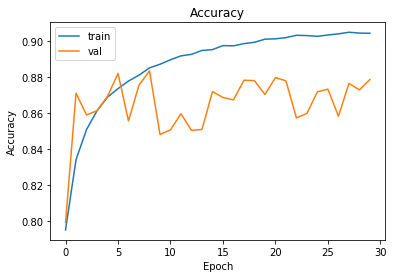

In [39]:
# plot accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

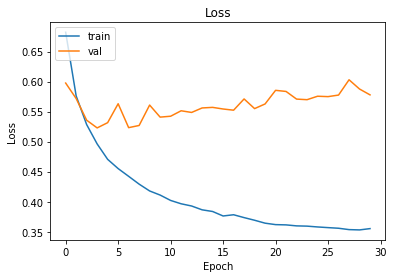

In [40]:
# Plot Loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Predict sentiment for test data using CNN
tokenizer.fit_on_texts(x_test)
sequences = tokenizer.texts_to_sequences(x_test)
test_data = pad_sequences(sequences, maxlen=max_len)
test_result = model_glove.evaluate(test_data, y_test)
print('Accuracy on Test data:%.2f' % (test_result[1]))

113691/113691 [==============================] - 7s 59us/step
Accuracy on Test data:0.72


## CNN With Custom Embeddings

In [ ]:
model_custom = Sequential()
model_custom.add(Embedding(vocabulary_size, 300, input_length=max_len, trainable=True))
model_custom.add(Dropout(0.2))

model_custom.add(Conv1D(64, 5, activation='relu'))
model_custom.add(MaxPooling1D(pool_size=4))

model_custom.add(Conv1D(64, 5, activation='relu'))
model_custom.add(MaxPooling1D(pool_size=4))

model_custom.add(Flatten())

model_custom.add(Dense(1, activation='sigmoid'))
model_custom.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Using class weight dictionary since the data is imbalanced.
class_weight = {0: 3.5,
                1: 1}

history = model_custom.fit(data, np.array(y_train), validation_split=0.4, class_weight=class_weight, epochs=30)

Train on 272857 samples, validate on 181906 samples
Epoch 1/30
272857/272857 [==============================] - 93s 341us/step - loss: 0.5573 - accuracy: 0.8449 - val_loss: 0.4785 - val_accuracy: 0.8696
Epoch 2/30
272857/272857 [==============================] - 93s 341us/step - loss: 0.3729 - accuracy: 0.9038 - val_loss: 0.4651 - val_accuracy: 0.8803
Epoch 3/30
272857/272857 [==============================] - 93s 340us/step - loss: 0.2474 - accuracy: 0.9376 - val_loss: 0.5129 - val_accuracy: 0.8868
Epoch 4/30
272857/272857 [==============================] - 93s 340us/step - loss: 0.1676 - accuracy: 0.9588 - val_loss: 0.6435 - val_accuracy: 0.8962
Epoch 5/30
272857/272857 [==============================] - 92s 339us/step - loss: 0.1242 - accuracy: 0.9695 - val_loss: 0.7107 - val_accuracy: 0.8933
Epoch 6/30
272857/272857 [==============================] - 93s 341us/step - loss: 0.1025 - accuracy: 0.9751 - val_loss: 0.7874 - val_accuracy: 0.8924
Epoch 7/30
272857/272857 [================

In [49]:
model_custom.save('model/cnn2_custom_e30')
np.save('model/cnn2_custom_history_e30.npy', history.history)
history=np.load('model/cnn2_custom_history_e30.npy',allow_pickle='TRUE').item()

RuntimeError: Unable to flush file's cached information (file write failed: time = Thu Aug  6 01:18:09 2020
, filename = 'model/cnn2_custom_e30', file descriptor = 43, errno = 28, error message = 'No space left on device', buf = 0x556965e331f0, total write size = 2048, bytes this sub-write = 2048, bytes actually written = 18446744073709551615, offset = 4096)

### Plot Accuracy and Loss

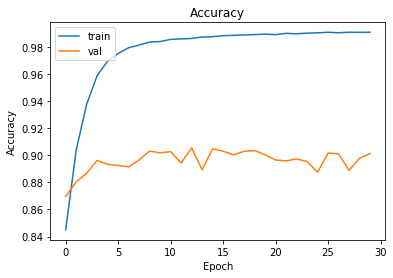

In [47]:
# plot accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

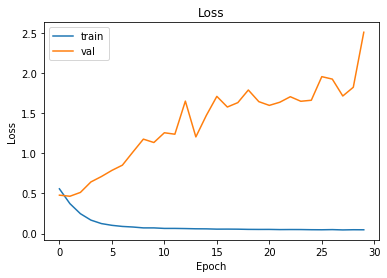

In [48]:
# Plot Loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [50]:
# Predict sentiment for test data using CNN with custom embedding
tokenizer.fit_on_texts(x_test)
sequences = tokenizer.texts_to_sequences(x_test)
test_data = pad_sequences(sequences, maxlen=max_len)
test_result = model_custom.evaluate(test_data, y_test)
print('Accuracy on Test data:%.2f' % (test_result[1]))

113691/113691 [==============================] - 7s 59us/step
Accuracy on Test data:0.73


## CNN With SMOTE Resampling

As mentioned in the exploratory data analysis, we do have an imbalanced dataset. The previous two models handle the imbalance by providing weights for each class in the training process. For this next model, we want to experiment with applying SMOTE sampling to create new data points for the minority class.

In [21]:
smote = SMOTE()

data_smote, y_train_smote = smote.fit_resample(data, y_train)

In [24]:
model_smote = Sequential()
model_smote.add(Embedding(vocabulary_size, 300, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_smote.add(Dropout(0.2))

model_smote.add(Conv1D(64, 5, activation='relu'))
model_smote.add(MaxPooling1D(pool_size=4))

model_smote.add(Conv1D(64, 5, activation='relu'))
model_smote.add(MaxPooling1D(pool_size=4))

model_smote.add(Flatten())

model_smote.add(Dense(1, activation='sigmoid'))
model_smote.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_smote.fit(data_smote, np.array(y_train_smote), validation_split=0.4, epochs=30)

Train on 426025 samples, validate on 284017 samples
Epoch 1/30
426025/426025 [==============================] - 65s 153us/step - loss: 0.3289 - accuracy: 0.8594 - val_loss: 1.6108 - val_accuracy: 0.3111
Epoch 2/30
426025/426025 [==============================] - 65s 153us/step - loss: 0.2809 - accuracy: 0.8835 - val_loss: 1.5062 - val_accuracy: 0.3963
Epoch 3/30
426025/426025 [==============================] - 65s 153us/step - loss: 0.2605 - accuracy: 0.8931 - val_loss: 1.8268 - val_accuracy: 0.3565
Epoch 4/30
426025/426025 [==============================] - 65s 153us/step - loss: 0.2487 - accuracy: 0.8995 - val_loss: 1.4089 - val_accuracy: 0.4368
Epoch 5/30
426025/426025 [==============================] - 65s 152us/step - loss: 0.2398 - accuracy: 0.9027 - val_loss: 1.7958 - val_accuracy: 0.3851
Epoch 6/30
426025/426025 [==============================] - 65s 153us/step - loss: 0.2327 - accuracy: 0.9059 - val_loss: 1.4694 - val_accuracy: 0.4460
Epoch 7/30
426025/426025 [================

In [49]:
model_smote.save('model/cnn2_smote_e30')
np.save('model/cnn2_smote_history_e30.npy', history.history)
history=np.load('model/cnn2_smote_history_e30.npy',allow_pickle='TRUE').item()

RuntimeError: Unable to flush file's cached information (file write failed: time = Thu Aug  6 01:18:09 2020
, filename = 'model/cnn2_custom_e30', file descriptor = 43, errno = 28, error message = 'No space left on device', buf = 0x556965e331f0, total write size = 2048, bytes this sub-write = 2048, bytes actually written = 18446744073709551615, offset = 4096)

### Plot Accuracy and Loss

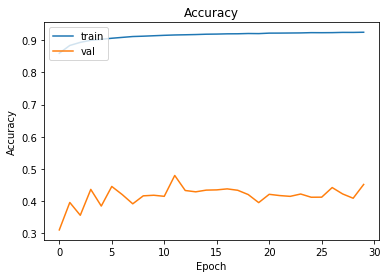

In [27]:
# plot accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

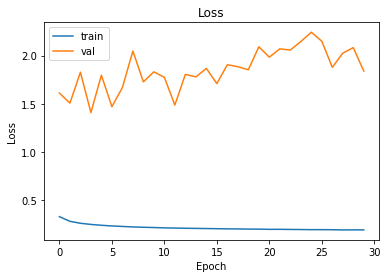

In [28]:
# Plot Loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Predict sentiment for test data using CNN with custom embedding
tokenizer.fit_on_texts(x_test)
sequences = tokenizer.texts_to_sequences(x_test)
test_data = pad_sequences(sequences, maxlen=max_len)
test_result = model_smote.evaluate(test_data, y_test)
print('Accuracy on Test data:%.2f' % (test_result[1]))

113691/113691 [==============================] - 7s 58us/step
Accuracy on Test data:0.76


## CNN With SMOTE Resampling and Custom Embeddings

In [29]:
model_custom_smote = Sequential()
model_custom_smote.add(Embedding(vocabulary_size, 300, input_length=max_len, trainable=True))
model_custom_smote.add(Dropout(0.2))

model_custom_smote.add(Conv1D(64, 5, activation='relu'))
model_custom_smote.add(MaxPooling1D(pool_size=4))

model_custom_smote.add(Conv1D(64, 5, activation='relu'))
model_custom_smote.add(MaxPooling1D(pool_size=4))

model_custom_smote.add(Flatten())

model_custom_smote.add(Dense(1, activation='sigmoid'))
model_custom_smote.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_custom_smote.fit(data_smote, np.array(y_train_smote), validation_split=0.4, epochs=30)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 426025 samples, validate on 284017 samples
Epoch 1/30
426025/426025 [==============================] - 145s 340us/step - loss: 0.2656 - accuracy: 0.8919 - val_loss: 1.8742 - val_accuracy: 0.3607
Epoch 2/30
426025/426025 [==============================] - 145s 340us/step - loss: 0.1815 - accuracy: 0.9303 - val_loss: 1.9121 - val_accuracy: 0.4009
Epoch 3/30
426025/426025 [==============================] - 145s 339us/step - loss: 0.1271 - accuracy: 0.9524 - val_loss: 2.2833 - val_accuracy: 0.4266
Epoch 4/30
426025/426025 [==============================] - 145s 340us/step - loss: 0.0914 - accuracy: 0.9666 - val_loss: 2.6572 - val_accuracy: 0.4273
Epoch 5/30
426025/426025 [==============================] - 145s 340us/step - loss: 0.0695 - accuracy: 0.9747 - val_loss: 3.5086 - val_accuracy: 0.4257
Epoch 6/30
426025/426025 [==============================] - 145s 340us/step - loss: 0.0566 - accuracy: 0.9796 - val_loss: 3.5283 - val_accuracy: 0.4422
Epoch 7/30
426025/426025 [==========

In [49]:
model_custom_smote.save('model/cnn2_custom_smote_e30')
np.save('model/cnn2_custom_smote_history_e30.npy', history.history)
history=np.load('model/cnn2_custom_smote_history_e30.npy',allow_pickle='TRUE').item()

RuntimeError: Unable to flush file's cached information (file write failed: time = Thu Aug  6 01:18:09 2020
, filename = 'model/cnn2_custom_e30', file descriptor = 43, errno = 28, error message = 'No space left on device', buf = 0x556965e331f0, total write size = 2048, bytes this sub-write = 2048, bytes actually written = 18446744073709551615, offset = 4096)

### Plot Accuracy and Loss

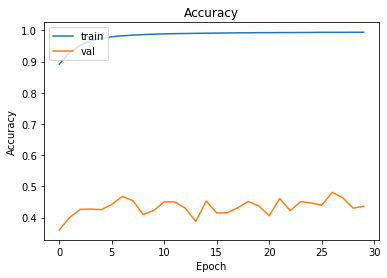

In [33]:
# plot accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

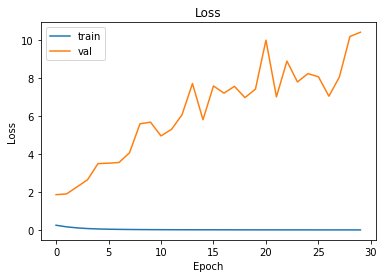

In [34]:
# Plot Loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
# Predict sentiment for test data using CNN with custom embedding

test_result = model_custom_smote.evaluate(test_data, y_test)
print('Accuracy on Test data:%.3f' % (test_result[1]))

113691/113691 [==============================] - 7s 57us/step
Accuracy on Test data:0.747


## Convolutional Neural Network + LSTM

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

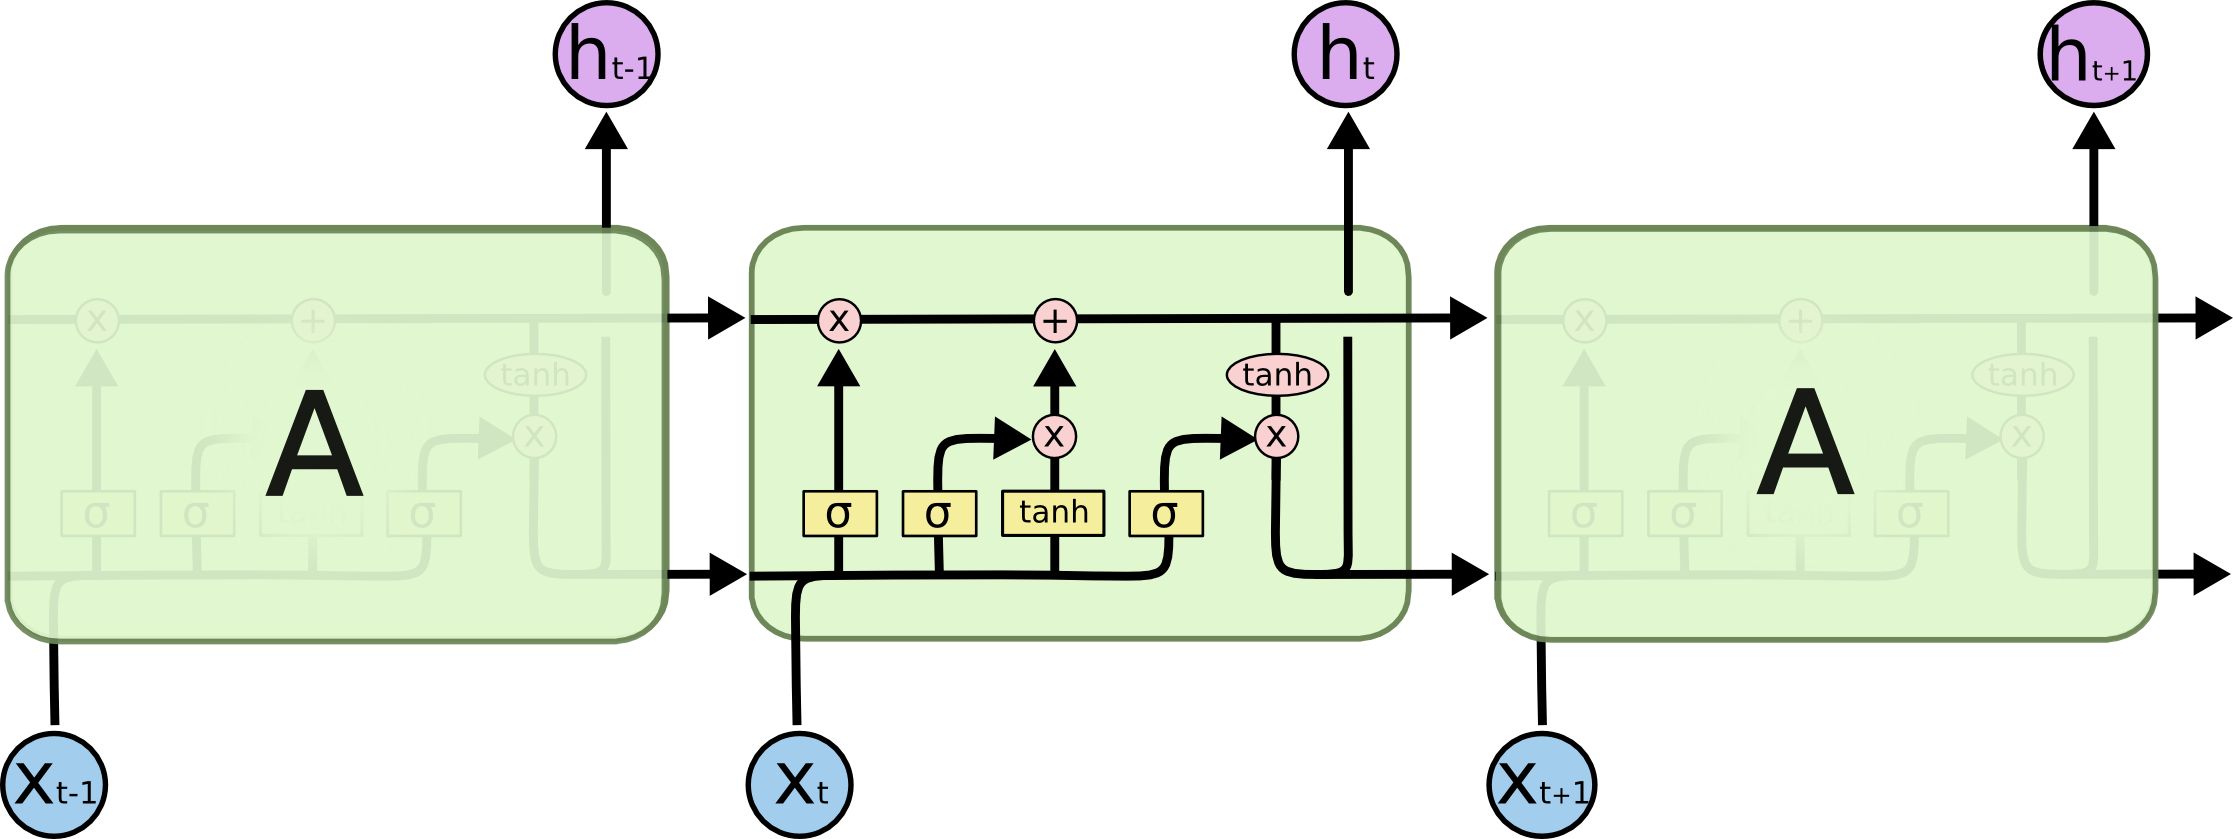

In [52]:
Image(filename='images/LSTM3.png', width=700)

In [27]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Embedding(vocabulary_size, 300, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_cnn_lstm.add(Dropout(0.2))

model_cnn_lstm.add(Conv1D(64, 5, activation='relu'))
model_cnn_lstm.add(MaxPooling1D(pool_size=4))

model_cnn_lstm.add(LSTM(100))

model_cnn_lstm.add(Dense(1, activation='sigmoid'))
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Using class weight dictionary since the data is imbalanced.
class_weight = {0: 3.5,
                1: 1}

history = model_cnn_lstm.fit(data, np.array(y_train), validation_split=0.4, class_weight=class_weight, epochs=10)

Train on 272857 samples, validate on 181906 samples
Epoch 1/10
272857/272857 [==============================] - 713s 3ms/step - loss: 0.5343 - accuracy: 0.8471 - val_loss: 0.4610 - val_accuracy: 0.8510
Epoch 2/10
272857/272857 [==============================] - 715s 3ms/step - loss: 0.4338 - accuracy: 0.8800 - val_loss: 0.4326 - val_accuracy: 0.9016
Epoch 3/10
272857/272857 [==============================] - 708s 3ms/step - loss: 0.3873 - accuracy: 0.8934 - val_loss: 0.4003 - val_accuracy: 0.8914
Epoch 4/10
272857/272857 [==============================] - 717s 3ms/step - loss: 0.3567 - accuracy: 0.9025 - val_loss: 0.4022 - val_accuracy: 0.8970
Epoch 5/10
272857/272857 [==============================] - 729s 3ms/step - loss: 0.3369 - accuracy: 0.9077 - val_loss: 0.4334 - val_accuracy: 0.9142
Epoch 6/10
272857/272857 [==============================] - 715s 3ms/step - loss: 0.3212 - accuracy: 0.9122 - val_loss: 0.3997 - val_accuracy: 0.8918
Epoch 7/10
272857/272857 [======================

In [31]:
model_cnn_lstm.save('model/cnn_lstm_glove_e10')
np.save('model/cnn_lstm_history_e10.npy', history.history)
history=np.load('model/cnn_lstm_history_e10.npy',allow_pickle='TRUE').item()

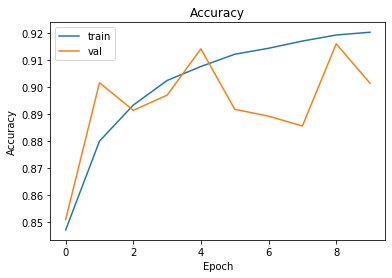

In [42]:
# plot accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

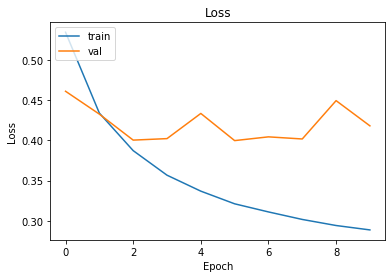

In [43]:
# Plot Loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
test_result = model_cnn_lstm.evaluate(test_data, y_test)
print('Accuracy on Test data:%.2f' % (test_result[1]))

113691/113691 [==============================] - 30s 264us/step
Accuracy on Test data:0.74
